<a id = 'select'></a>
# Model Validation

## Table of Content

[A. Individual Account](#indi)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
from collections import OrderedDict
import argparse
import json
import pickle
from datetime import datetime
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve,roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from imblearn.over_sampling import SMOTE
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Mounting the Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = 'indi'></a>
> ## A. Individual Account

In [3]:
inv_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Individual_clean_ML.csv')

In [4]:
inv_df.head()

,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,cibil_score,bal_annual_inc,inst_anmt_ratio,credit_line_ratio
0,1,13.99,6912.03,5,21,10,4,14.943679,0,0,5.91,0,155342.26,29.7,1,0,677,0.065455,0.034175,0.538462
1,1,11.99,46084.68,5,24,10,4,15.110733,0,0,16.06,0,1206220.03,19.2,4,0,717,0.380000,0.033210,0.578947
2,2,14.85,46625.15,5,20,10,4,15.636826,2,1,17.06,0,438329.23,11.6,1,0,787,0.318182,0.023711,0.764706
3,2,22.45,16287.62,2,9,3,4,15.584891,2,0,25.37,0,1232007.40,64.5,6,0,697,0.099585,0.027876,0.342857
4,1,13.44,22763.68,5,22,4,3,14.462706,2,0,10.20,0,495634.52,68.4,0,0,692,0.351471,0.033906,0.833333


In [5]:
X = inv_df.drop(columns = {'loan_status'})
Y = inv_df['loan_status']

In [6]:
# Splitting Dataset into Test & Train

target_col = 'loan_status'

#feature space
X_train = inv_df.drop(columns=[target_col])
X_test = inv_df.drop(columns=[target_col])

#target variable
y_train = inv_df[target_col]
y_test = inv_df[target_col]

In [7]:
drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','revol_bal','revol_util']

In [8]:
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [10]:
df_fico_grade = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/grade_to_fico.csv')
df_fico_grade.head()

,sub_grade,score,value
0,A1,789,34
1,A2,780,33
2,A3,769,32
3,A4,761,31
4,A5,741,30


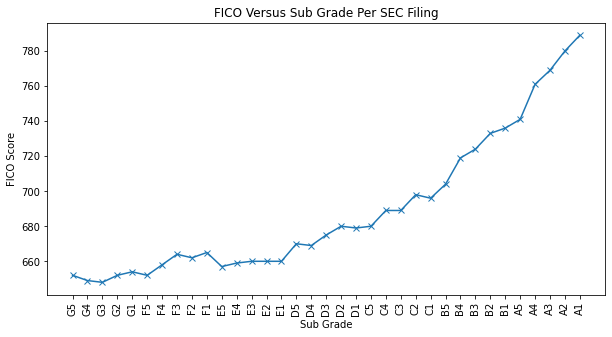

In [12]:
plt.figure(figsize=(10,5))
plt.plot(df_fico_grade['value'], df_fico_grade['score '], marker='x')
plt.xticks(range(df_fico_grade.shape[0]) , df_fico_grade['sub_grade'][::-1], rotation='vertical')
plt.xlabel('Sub Grade')
plt.ylabel("FICO Score")
plt.title("FICO Versus Sub Grade Per SEC Filing")
plt.savefig(os.path.join('fico_grade_line.png'))
plt.show()

In [13]:
#instantiate regressor
knn = KNeighborsRegressor(n_neighbors=1)
#fit to data
knn.fit(np.reshape(df_fico_grade['score '].values, (-1, 1)), 
        df_fico_grade['value'])
#make sample prediction
knn.predict(np.reshape([750], (1,-1)))[0]

30.0

In [14]:
#save the model
with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/model/knn_regression.pkl'), 'wb') as handle:
    pickle.dump(knn,handle)

In [16]:
df_fico_apr = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/grade_to_apr.csv')
df_fico_apr.head()

,grade_num,loan_grade,apr,36_mo,60_mo
0,34,A1,6.03,6.78,7.30
1,33,A2,6.97,7.99,8.26
2,32,A3,7.62,8.99,8.91
3,31,A4,8.60,9.98,9.91
4,30,A5,9.25,10.99,10.56


In [17]:
df_fico_apr[df_fico_apr['grade_num']==30]['36_mo']

4    10.99
Name: 36_mo, dtype: float64

In [19]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1,
                           scale_pos_weight=estimate)

clf.fit(X_train, y_train)

#make predictions
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

Estimate: 0.980


array([[758784, 300426],
       [287061, 793557]])

In [20]:
fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1],pos_label=1)

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       clf.predict_proba(X_test)[:,1],
                                                       pos_label=1)

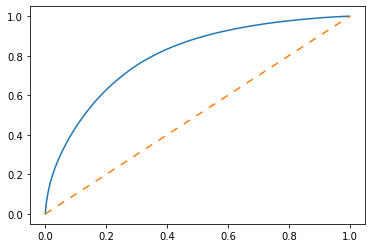

In [22]:
plt.plot(fpr, tpr, label='XGB')
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.show()

In [23]:
xgb_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print("xgb_auc: {}".format(xgb_auc))

xgb_auc: 0.797374797321077


In [24]:
f1_xgb = f1_score(y_test, y_pred)

print("f1_xgb (binary): {}\n".format(f1_xgb))
print(classification_report(y_test,y_pred))

f1_xgb (binary): 0.7298414743670217

              precision    recall  f1-score   support

           0       0.73      0.72      0.72   1059210
           1       0.73      0.73      0.73   1080618

    accuracy                           0.73   2139828
   macro avg       0.73      0.73      0.73   2139828
weighted avg       0.73      0.73      0.73   2139828



In [26]:
#define location to save trained model
save_model_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/model/xgb_cv_compact.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle)

Saving model at: /content/drive/MyDrive/Colab Notebooks/model/xgb_cv_compact.pkl


In [27]:
#get input
fico = 800
loan_amnt = 1000
term = '36 months'
dti = 2
home_ownership = 'rent'
mort_acc = 5
annual_inc = 50_000
open_acc = 5
employment = 'nurse'
verification_status = 1
revol_util = 60
application_type = 0
total_acc=1

In [28]:
#calculate grade from FICO
sub_grade = knn.predict(np.reshape([fico], (1,-1)))[0]
#calculate grade
grade = round(sub_grade/5) + 1
#get interest rate
apr_row = df_fico_apr[df_fico_apr['grade_num']==sub_grade]

In [29]:
apr_row

,grade_num,loan_grade,apr,36_mo,60_mo
0,34,A1,6.03,6.78,7.3


In [30]:
if term=='36 months':
    int_rate = apr_row['36_mo'].values[0]
    installment = float(loan_amnt)/36
            
else:
    int_rate = apr_row['60_mo'].values[0]
    installment = float(loan_amnt)/60

In [31]:
term_to_int = {'36 months': 1, '60 months': 2}
home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }

In [32]:
X_train.columns

Index(['term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'mort_acc', 'cibil_score', 'bal_annual_inc', 'inst_anmt_ratio',
       'credit_line_ratio'],
      dtype='object')

In [33]:
feature_list=['term','sub_grade','home_ownership', 'annual_inc', 'verification_status',
       'dti','revol_util', 'mort_acc','credit_hist', 'credit_line_ratio',
       'balance_annual_inc', 'fico_avg_score', 'inst_amnt_ratio']

In [34]:
temp = pd.DataFrame(index=[1])
temp['term']=term_to_int[term]
temp['sub_grade']=sub_grade
temp['home_ownership']=home_to_int[home_ownership.upper()]
temp['annual_inc']=np.log(annual_inc)
temp['verification_status']=verification_status
temp['dti']=dti
temp['revol_util']=revol_util
temp['mort_acc'] = mort_acc
temp['credit_hist']=20
temp['credit_line_ratio']=open_acc/total_acc
temp['balance_annual_inc']=loan_amnt/annual_inc
temp['fico_avg_score'] = fico
temp['inst_amnt_ratio']=installment/loan_amnt

In [35]:
temp

,term,sub_grade,home_ownership,annual_inc,verification_status,dti,revol_util,mort_acc,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
1,1,34.0,3,10.819778,1,2,60,5,20,5.0,0.02,800,0.027778
